In [359]:
import torch 
from torch.utils.data import Dataset, DataLoader 
from torch import nn
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
from sklearn.model_selection import train_test_split
import os
torch.manual_seed(42)

In [360]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

1. Dataset contains Monthly and Daily prices of Natural gas, starting from January 1997 to current 
year. Prices are in nominal dollars. The task is to predict the price of natural gas using RNN model 
for the dataset  

    https://datahub.io/core/natural-gas#resource-daily  or  
    https://www.kaggle.com/datasets/joebeachcapital/natural-gas-prices 

    Given the price of last ten 10 days, corresponds to sequence_length, the RNN model must predict 
    the price for the 11th day. 

In [361]:
df=pd.read_csv('data.csv')
df=df.dropna()
df

,Date,Price
0,2025-03-10,4.23
1,2025-03-07,4.39
2,2025-03-06,4.39
3,2025-03-05,4.40
4,2025-03-04,4.39
...,...,...
7074,1997-01-13,4.00
7075,1997-01-10,3.92
7076,1997-01-09,3.61
7077,1997-01-08,3.80


In [362]:
y = df['Price'].values 
x = np.arange(1, len(y), 1)

In [363]:
minm = y.min() 
maxm = y.max() 
y = (y - minm) / (maxm - minm)

In [364]:
sequence_length = 10
X = [] 
Y = [] 
for i in range(len(y) - sequence_length): 
    l = [] 
    for j in range(i, i + sequence_length): 
        l.append(y[j]) 
    X.append(l) 
    Y.append(y[j + 1])
    
X=np.array(X)
Y=np.array(Y)

In [365]:
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

In [366]:
class PriceTimeSeries(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    def __len__(self):
        return self.x.shape[0]
    
train_set = PriceTimeSeries(x_train,y_train)
train_loader = DataLoader(train_set,shuffle=True,batch_size=256)

In [367]:
class RNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn=nn.RNN(input_size=1, hidden_size=5, num_layers=1, batch_first=True)
        self.fc=nn.Linear(5,1)
    def forward(self, x):
        x,_=self.rnn(x)
        x=x[:,-1,:]
        x=self.fc(torch.relu(x))
        return x

In [368]:
model=RNNModel().to(device)

In [369]:
alpha=0.0001
epochs=500

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=alpha) 

In [370]:
def train(model, epochs, train_loader, criterion, optimizer):
    losses = []
    for epoch in range(epochs):
        running_loss = 0.0
        model.train()
        for input, output in train_loader:
            input, output = input.to(device), output.to(device)
            optimizer.zero_grad()
            pred = model(input.view(-1, sequence_length,1))
            loss = criterion(pred, output.view(-1, 1))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")
        losses.append(running_loss / len(train_loader))
    return losses

losses = train(model, epochs, train_loader, criterion, optimizer)

Epoch 1/500, Loss: 0.01846571201863496
Epoch 2/500, Loss: 0.015144467333574657
Epoch 3/500, Loss: 0.013100781032572622
Epoch 4/500, Loss: 0.011050370238397432
Epoch 5/500, Loss: 0.009423944491731085
Epoch 6/500, Loss: 0.008551219397264978
Epoch 7/500, Loss: 0.007493559352081755
Epoch 8/500, Loss: 0.00696985783946255
Epoch 9/500, Loss: 0.006360102009595088
Epoch 10/500, Loss: 0.006163787623138532
Epoch 11/500, Loss: 0.0057976711440183544
Epoch 12/500, Loss: 0.005774543175230856
Epoch 13/500, Loss: 0.00585380133808307
Epoch 14/500, Loss: 0.005760311776691157
Epoch 15/500, Loss: 0.005565232374583898
Epoch 16/500, Loss: 0.005429544233028655
Epoch 17/500, Loss: 0.005432125535267202
Epoch 18/500, Loss: 0.0055610586119734726
Epoch 19/500, Loss: 0.00540936262468281
Epoch 20/500, Loss: 0.005315850215518604
Epoch 21/500, Loss: 0.005248322445170387
Epoch 22/500, Loss: 0.005442882483096227
Epoch 23/500, Loss: 0.00536991457414368
Epoch 24/500, Loss: 0.005266944452634324
Epoch 25/500, Loss: 0.005297

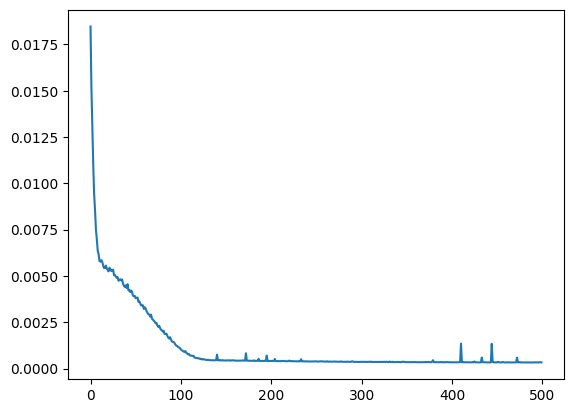

In [371]:
plt.plot(losses)

In [372]:
test_set = PriceTimeSeries(x_train,y_train)
test_loader = DataLoader(test_set,shuffle=False,batch_size=256)

In [373]:
def evaluate(model, test_loader):
    model.eval()
    preds = []
    labels = []
    
    with torch.no_grad():
        for input, output in test_loader:
            input, output = input.to(device), output.to(device)
            pred = model(input.view(-1, sequence_length, 1)).view(-1)
            preds.extend(pred.detach().cpu().numpy())
            labels.extend(output.view(-1).detach().cpu().numpy())
    
    preds=np.array(preds)
    labels=np.array(labels)
    
    return preds, labels

preds,labels = evaluate(model, test_loader)

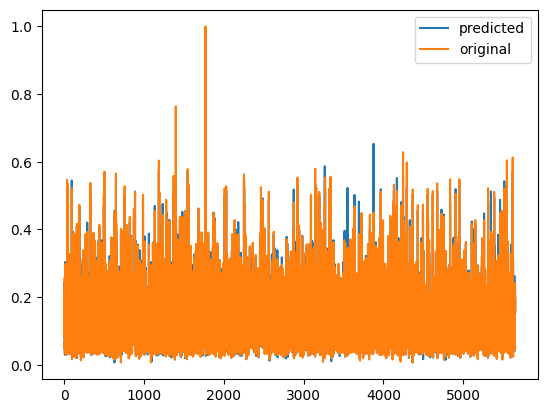

In [374]:
plt.plot(preds,label='predicted')
plt.plot(labels,label='original')
plt.legend()

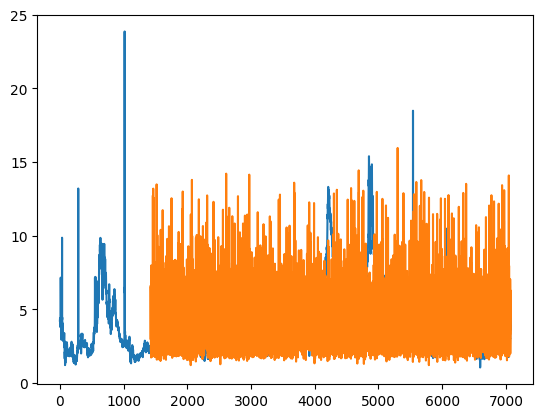

In [375]:
y = y * (maxm - minm) + minm
y_pred = preds * (maxm - minm) + minm
plt.plot(y)
plt.plot(range(len(y)-len(y_pred), len(y)), y_pred)
plt.show()

2. The data provided at the link https://download.pytorch.org/tutorial/data.zip consists of
names stored in the format {language: [names ...]} i.e. each language contains a list of
names. Train a RNN on a few thousand surnames from 18 languages of origin, and
predict which language a name is from based on the spelling.

In [376]:
data_path='data/names'

names = []
languages = [] 

for filename in os.listdir(data_path):
    lang = filename[:-4]
    file_path = os.path.join(data_path, filename)
    with open(file_path, 'r') as f:
        for line in f:
            names.append(line.strip())  
            languages.append(lang)                      

In [377]:
x_train, x_test, y_train, y_test = train_test_split(names,languages,test_size=0.2,random_state=42)

In [378]:
def prepare_data(names, languages):
    all_chars = set(''.join(names))
    char_to_index = {ch: i+1 for i, ch in enumerate(all_chars)}
    char_to_index['<PAD>'] = 0
    
    language_to_index = {language: i for i, language in enumerate(set(languages))}
    
    max_length = max(len(name) for name in names)
    name_indices = []
    for name in names:
        indices = [char_to_index.get(char, 0) for char in name]
        name_indices.append(indices + [0] * (max_length - len(indices)))
    
    label_indices = [language_to_index[label] for label in languages]
    
    return np.array(name_indices), np.array(label_indices), char_to_index, language_to_index, max_length

x_train_indices, y_train_indices, char_to_index, language_to_index, max_length = prepare_data(x_train, y_train)
x_test_indices, y_test_indices, _, _, _ = prepare_data(x_test, y_test)

In [379]:
class NameLanguageDataset(Dataset):
    def __init__(self, names, labels):
        self.names = torch.tensor(names, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.long)
    
    def __len__(self):
        return len(self.names)
    
    def __getitem__(self, idx):
        return self.names[idx], self.labels[idx]
    
train_dataset = NameLanguageDataset(x_train_indices, y_train_indices)
test_dataset = NameLanguageDataset(x_test_indices, y_test_indices)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [382]:
class NameLanguageRNN(nn.Module):
    def __init__(self):
        super(NameLanguageRNN, self).__init__()
        self.hidden_size = 128
        self.max_length = max_length
        self.embedding = nn.Embedding(len(char_to_index), 128)
        self.rnn = nn.RNN(128, 128, batch_first=True)
        self.fc = nn.Linear(128, len(language_to_index))
    
    def forward(self, x):
        embedded = self.embedding(x)
        out, _ = self.rnn(embedded)
        last_hidden = out[:, -1, :]
        out = self.fc(last_hidden)
        return out

In [384]:
model=NameLanguageRNN().to(device)

In [391]:
def train_model(model, train_loader, num_epochs=10, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch_data, batch_labels in train_loader:
            batch_data,batch_labels=batch_data.to(device), batch_labels.to(device)
            optimizer.zero_grad()
            outputs = model(batch_data)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

In [395]:
def predict(model, name, char_to_index, language_to_index, max_length):
    name_indices = [char_to_index.get(char, 0) for char in name]
    name_indices = name_indices + [0] * (max_length - len(name_indices))
    
    with torch.no_grad():
        model.eval()
        input_tensor = torch.tensor([name_indices], dtype=torch.long).to(device)
        outputs = model(input_tensor)
        predicted_language_index = torch.argmax(outputs, dim=1).item()
        predicted_language = list(language_to_index.keys())[predicted_language_index]
        return predicted_language

In [396]:
train_model(model, train_loader, num_epochs=10)

Epoch 1/10, Loss: 1.8515016695417732
Epoch 2/10, Loss: 1.8494806413156577
Epoch 3/10, Loss: 1.8498690612762572
Epoch 4/10, Loss: 1.8511257437595807
Epoch 5/10, Loss: 1.8512114462149571
Epoch 6/10, Loss: 1.851620648961618
Epoch 7/10, Loss: 1.8507819997361932
Epoch 8/10, Loss: 1.8495719884021349
Epoch 9/10, Loss: 1.8497352186902112
Epoch 10/10, Loss: 1.8473655075665965


In [397]:
test_name = "Smith"
predicted_language = predict(model, test_name, char_to_index, language_to_index, max_length)
print(f"The predicted language for the name '{test_name}' is: {predicted_language}")

The predicted language for the name 'Smith' is: Russian
